# Testing U-net testing Malaria Images

Testing U-net with images of P. vivax (malaria) infected human blood smears

https://www.kaggle.com/kmader/malaria-bounding-boxes

In [1]:
import numpy as np
import os
import sys
import random
import warnings

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from datetime import date

import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


from keras.optimizers import Adam

#import tensorflow as tf

Using TensorFlow backend.


## Loading Images

### Parameters

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

TRAIN_PATH = '../../data/raw_data/malaria/transformed_images/'
TEST_PATH = 'stage1_test/'

#MASK_CATEGORIES = ['trophozoite','ring', 'schizont', 'gametocyte']
MASK_CATEGORIES = ['trophozoite']
STR_MASK_CATEGORIES = '_'.join(MASK_CATEGORIES)

#warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [3]:
train_ids = np.load(TRAIN_PATH+'malaria_train_transformed_256_256_names.npy')
X_train = np.load(TRAIN_PATH+'malaria_train_transformed_256_256.npy')
Y_train =  np.load(TRAIN_PATH+'malaria_train_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy')

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [4]:
test_ids = np.load(TRAIN_PATH+'malaria_test_transformed_256_256_names.npy')
X_test = np.load(TRAIN_PATH+'malaria_test_transformed_256_256.npy')
Y_test =  np.load(TRAIN_PATH+'malaria_test_transformed_256_256_masks_'+STR_MASK_CATEGORIES+'.npy')

In [5]:
print(X_train.shape)
print(Y_train.shape)

(1208, 256, 256, 3)
(1208, 256, 256, 1)


In [6]:
print(X_test.shape)
print(Y_test.shape)

(120, 256, 256, 3)
(120, 256, 256, 1)


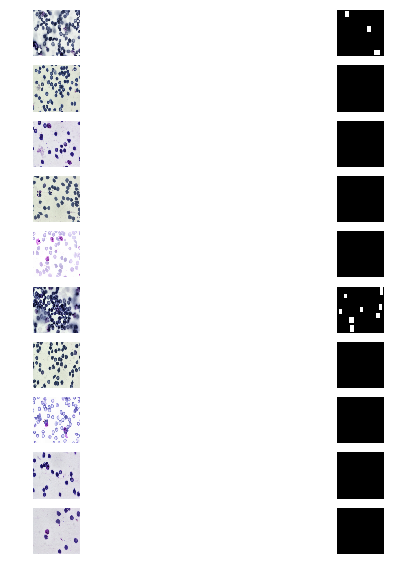

In [7]:
n_images = 10

fig, axes = plt.subplots(n_images,2,figsize=(10,10))
for i in range(n_images):
    #ix = random.randint(0, len(train_ids))
    ix = i
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

### BALANCE DATA SET

In [8]:
n_images = train_ids.shape[0]

count_no_mask = 0
count_img_mask = 0
rand_filter_count = 0
delete_index = []

for i in range(n_images):
    #ix = random.randint(0, len(train_ids))
    if (np.sum(Y_train[i].reshape(-1)) > 0):
        count_img_mask += 1
    else:
        count_no_mask += 1
        if (np.random.rand(1) > 1 ):
            rand_filter_count += 1
        else:
            delete_index.append(i)
        

print("Total images: " + str(n_images))
print("Total images without masks: " + str(count_no_mask))
print("Total images without masks with filter: " + str(rand_filter_count))
print("Total images with masks: " + str(count_img_mask))
print(len(delete_index))

Total images: 1208
Total images without masks: 612
Total images without masks with filter: 0
Total images with masks: 596
612


In [9]:
X_train_balanced = np.delete(X_train, delete_index, 0)
Y_train_balanced = np.delete(Y_train, delete_index, 0)

In [10]:
print(X_train_balanced.shape)
print(Y_train_balanced.shape)

(596, 256, 256, 3)
(596, 256, 256, 1)


### IoU (Intersection of the union)
The intersection of the union(IOU): Measure the total number of shared pixels after applying the masks

\begin{equation*}
  IOU = \frac{I_1 \cup I_2}{I_1 \cap I_2}
\end{equation*}

In [11]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    smooth=1
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    #return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())
    return (K.sum(intersection, axis=-1)) / (K.sum(union, axis=-1) )

In [12]:
def get_metrics_grafics(results):
    # 'val_loss', 'val_my_iou_metric', 'loss', 'iou_loss_core'
    plt.figure(figsize=(20,10))
    ## LOSS
    plt.subplot(221)
    plt.plot(results.history['loss'], label='Training loss')
    plt.plot(results.history['val_loss'], label='Validation loss')
    plt.legend(frameon=False)
    ## Intersection over union
    plt.subplot(222)
    plt.plot(results.history['iou_loss_core'], label='Training IoU')
    plt.plot(results.history['val_iou_loss_core'], label='Validation IoU')
    plt.legend(frameon=False)

    plt.show()

## U-Net

![title](../../u-net-architecture.png)

In [13]:
def unet(input_size = (128,128,3), dropout_rate=0.2, learning_rate=0.004):
    inputs = Input(input_size)

    
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(dropout_rate)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(dropout_rate)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])

    model.compile(optimizer = Adam(lr = learning_rate), loss = 'binary_crossentropy', metrics = [iou_loss_core])

    return model

In [14]:
MODEL_ID = 0
TODAY =  date.today().strftime("%Y%m%d")
str_masks_name = '_'.join(MASK_CATEGORIES)

### Test Model

In [15]:
model = unet(input_size = (IMG_HEIGHT,IMG_WIDTH,3), dropout_rate=0.2, learning_rate=0.0004)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxP

In [16]:
model_name = "model-unet-malaria-kaggle-" + TODAY + "_" + str_masks_name + "_" + str(MODEL_ID)+".h5"
print(model_name)

model-unet-malaria-kaggle-20190803_trophozoite_0.h5


In [17]:
results = model.fit(X_train_balanced, Y_train_balanced, validation_split=0.2, batch_size=5, epochs=20)

Instructions for updating:
Use tf.cast instead.
Train on 476 samples, validate on 120 samples
Epoch 1/20
476/476 [==============================] - 24s 50ms/step - loss: 0.3936 - iou_loss_core: nan - val_loss: 0.2908 - val_iou_loss_core: nan
Epoch 2/20
476/476 [==============================] - 19s 40ms/step - loss: 0.3895 - iou_loss_core: nan - val_loss: 0.2908 - val_iou_loss_core: nan
Epoch 3/20
476/476 [==============================] - 20s 42ms/step - loss: 0.3895 - iou_loss_core: nan - val_loss: 0.2908 - val_iou_loss_core: nan
Epoch 4/20
476/476 [==============================] - 20s 42ms/step - loss: 0.3895 - iou_loss_core: nan - val_loss: 0.2908 - val_iou_loss_core: nan
Epoch 5/20
476/476 [==============================] - 20s 42ms/step - loss: 0.3895 - iou_loss_core: nan - val_loss: 0.2908 - val_iou_loss_core: nan
Epoch 6/20
 80/476 [====>.........................] - ETA: 15s - loss: 0.4388 - iou_loss_core: nan

KeyboardInterrupt: 

In [17]:
checkpointer = ModelCheckpoint(model_name, monitor='iou_loss_core',verbose=1, save_best_only=True)


results = model.fit(X_train_balanced, Y_train_balanced, validation_split=0.1, batch_size=8, epochs=50, 
                    callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Train on 536 samples, validate on 60 samples
Epoch 1/50
536/536 [==============================] - 24s 45ms/step - loss: 0.3830 - iou_loss_core: 0.9606 - val_loss: 0.2694 - val_iou_loss_core: 0.9833

Epoch 00001: iou_loss_core improved from inf to 0.96056, saving model to model-unet-malaria-kaggle-20190803_trophozoite_0.h5
Epoch 2/50
536/536 [==============================] - 20s 37ms/step - loss: 0.3809 - iou_loss_core: 0.9764 - val_loss: 0.2694 - val_iou_loss_core: 0.9833

Epoch 00002: iou_loss_core did not improve from 0.96056
Epoch 3/50
536/536 [==============================] - 20s 37ms/step - loss: 0.3809 - iou_loss_core: 0.9764 - val_loss: 0.2694 - val_iou_loss_core: 0.9833

Epoch 00003: iou_loss_core did not improve from 0.96056
Epoch 4/50
536/536 [==============================] - 20s 37ms/step - loss: 0.3809 - iou_loss_core: 0.9764 - val_loss: 0.2694 - val_iou_loss_core: 0.9833

Epoch 00004: iou_loss_core did not improve from 0.

536/536 [==============================] - 20s 37ms/step - loss: 0.3809 - iou_loss_core: 0.9764 - val_loss: 0.2694 - val_iou_loss_core: 0.9833

Epoch 00038: iou_loss_core did not improve from 0.96056
Epoch 39/50
536/536 [==============================] - 20s 37ms/step - loss: 0.3809 - iou_loss_core: 0.9764 - val_loss: 0.2694 - val_iou_loss_core: 0.9833

Epoch 00039: iou_loss_core did not improve from 0.96056
Epoch 40/50
536/536 [==============================] - 20s 37ms/step - loss: 0.3809 - iou_loss_core: 0.9764 - val_loss: 0.2694 - val_iou_loss_core: 0.9833

Epoch 00040: iou_loss_core did not improve from 0.96056
Epoch 41/50
536/536 [==============================] - 20s 37ms/step - loss: 0.3809 - iou_loss_core: 0.9764 - val_loss: 0.2694 - val_iou_loss_core: 0.9833

Epoch 00041: iou_loss_core did not improve from 0.96056
Epoch 42/50
536/536 [==============================] - 20s 37ms/step - loss: 0.3809 - iou_loss_core: 0.9764 - val_loss: 0.2694 - val_iou_loss_core: 0.9833

Epoch 00

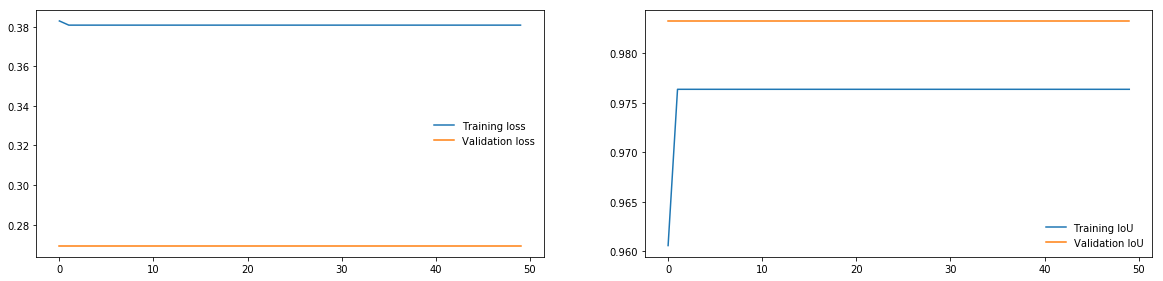

In [18]:
get_metrics_grafics(results)

In [ ]:
MODEL_ID +=1

In [19]:
results_test = model.evaluate(x = X_test, y = Y_test)

120/120 [==============================] - 5s 38ms/step


In [20]:
results_test

[0.145214914282163, 0.9909905751546224]

## Predictions

In [21]:
# Predict on train, val and test
model = load_model(model_name, custom_objects={'iou_loss_core': iou_loss_core})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (X_test[i].shape[0], X_test[i].shape[1]), 
                                       mode='constant', preserve_range=True))

120/120 [==============================] - 1s 10ms/step


### IMAGE |  MASK | PREDICTION

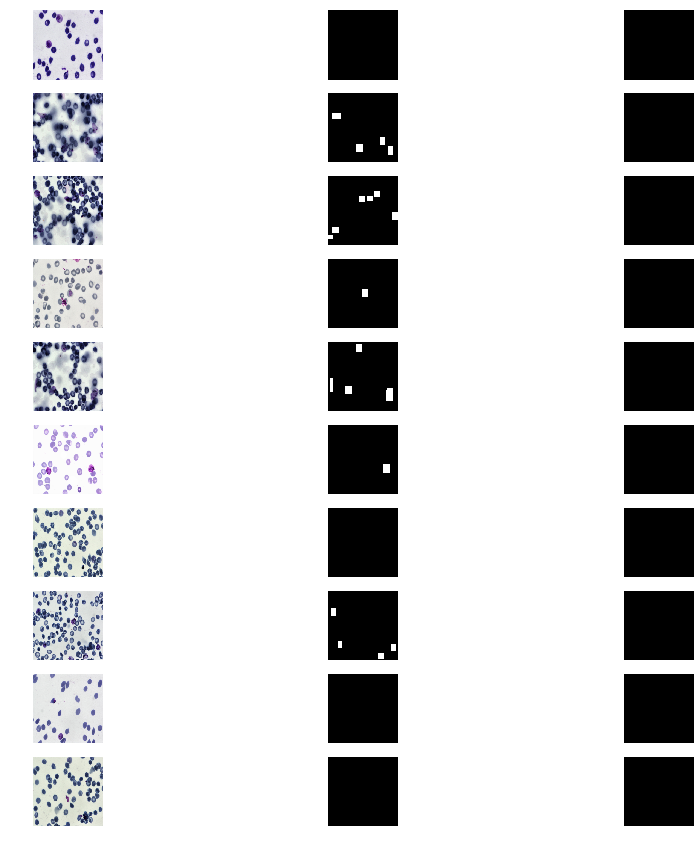

In [22]:
n_images = 10

fig, axes = plt.subplots(n_images,3,figsize=(15,15))

for i in range(n_images):
    ix = random.randint(0, len(preds_train_t-1))
    axes[i,0].imshow(X_train[ix])
    axes[i,1].imshow(np.squeeze(Y_train[ix]), cmap='gray')
    axes[i,2].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')

fig = plt.gcf()
for ax in fig.axes:
    ax.axis('off')

plt.show()

In [ ]:
def castF(x):
    return K.cast(x, K.floatx())

def castB(x):
    return K.cast(x, bool)

def iou_loss_core(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

In [78]:
y_hat = preds_train_t[0]
y = Y_train[0]
smooth=1

print(np.sum(y))
print(np.sum(y_hat))


intersection = y * y_hat
print(np.sum(intersection))

notTrue = 1 - y
print(np.sum(notTrue))
union = y + (notTrue * y_hat)

print(np.sum(union))

(np.sum(intersection) ) / (np.sum(union) )

1985
0
0
63551
1985


0.0

In [63]:
y_hat = np.ones_like(Y_train[0])
y = Y_train[0]
smooth=1
y
print(K.sum(y, axis=-1))
print(K.sum(y_hat, axis=-1))
np.ones_like(Y_train[0])
intersection = y * y_hat
print(K.sum(intersection, axis=-1))

notTrue = 1 - y
union = y + (notTrue * y_hat)
print(K.sum(union, axis=-1))

(K.sum(intersection, axis=-1) + smooth) / (K.sum(union, axis=-1) + smooth)

Tensor("Sum_74:0", shape=(256, 256), dtype=uint8)
Tensor("Sum_75:0", shape=(256, 256), dtype=uint8)
Tensor("Sum_76:0", shape=(256, 256), dtype=uint8)
Tensor("Sum_77:0", shape=(256, 256), dtype=uint8)


<tf.Tensor 'truediv_11:0' shape=(256, 256) dtype=float32>

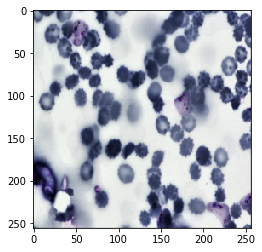

In [62]:
plt.imshow(X_train[0] )

In [ ]:
plt.imshow(X_train[0] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[0]>0, 1, np.nan)), cmap='Set1',alpha=0.7)


In [ ]:
plt.imshow(X_train[4] ) 

In [ ]:
plt.imshow(X_train[4] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[4]>0,1, np.nan)), cmap='Set1',alpha=0.7)

In [ ]:
plt.imshow(X_train[7] ) 

In [ ]:
plt.imshow(X_train[7] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[7]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

In [ ]:
plt.imshow(X_train[9] )

In [ ]:
plt.imshow(X_train[9] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[9]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

In [ ]:
plt.imshow(X_train[50] ) 

In [ ]:
plt.imshow(X_train[50] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(preds_train_t[50]>0, 1, np.nan)), cmap='Set1',alpha=0.7)

In [ ]:
plt.imshow(X_train[50] )    # Also set the cmap to gray
plt.imshow(np.squeeze(np.where(Y_train[50]>0, 1, np.nan)), cmap='Set1',alpha=0.7)